# Canny Edge Detection Algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data

## Steps
- Gaussian Filter // noise reduction
- Gradients
- Non-Maximum Suppression
- Double threshold
- Edge tracking by hysteresis

In [2]:
def show_image(image, title='image' , cmap_type = 'gray'):
    plt.imshow(image, cmap = cmap_type)
    plt.axis('off')
    plt.show()

In [3]:
def plot_comparison(original, filtered, title_filtered):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 10), sharex=True,sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(title_filtered)
    ax2.axis('off')

In [4]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])  # Y' = 0.2989 R + 0.5870 G + 0.1140 B 

In [5]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

In [6]:
def convolution2d(image, kernel):
    m, n = kernel.shape
    if (m == n):
        y, x = image.shape
        y = y - m + 1
        x = x - m + 1
        new_image = np.zeros((y,x))
        for i in range(y):
            for j in range(x):
                new_image[i][j] = np.sum(image[i:i+m, j:j+m]*kernel)
    return new_image

In [7]:
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = convolution2d(img, Kx)
    Iy = convolution2d(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

In [8]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

In [9]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

In [10]:
def hysteresis(img, weak=25, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

In [11]:
def diy_canny(img, sigma=1, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    image_gray = rgb2gray(img)
    image_sharp = convolution2d(image_gray, gaussian_kernel(2, sigma))
    image_new, theta = sobel_filters(image_sharp)
    image_new_sup = non_max_suppression(image_new, theta)
    image_new_thr, _ , _ = threshold(image_new_sup, lowThresholdRatio, highThresholdRatio)
    image_new_hys = hysteresis(image_new_thr)
    
    return image_new_hys

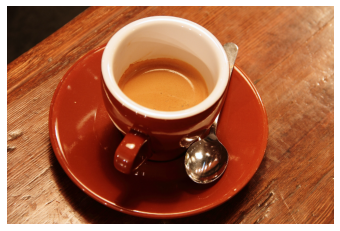

In [12]:
image = data.coffee()
show_image(image)

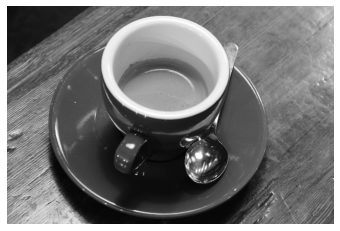

(400, 600)


In [13]:
image_gray = rgb2gray(image)  ### Decreasing channel size from 3 to 1 for easy convolution 
show_image(image_gray)
print(image_gray.shape) ### 2-D array

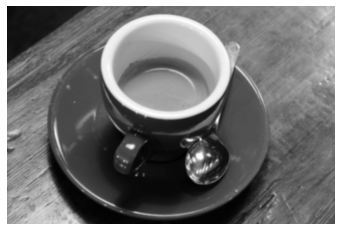

In [14]:
image_sharp = convolution2d(image_gray, gaussian_kernel(6))
show_image(image_sharp)

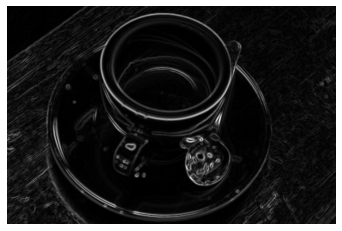

In [15]:
image_new, theta = sobel_filters(image_sharp)
show_image(image_new) ## edge thickness are various and intensity levels are different.

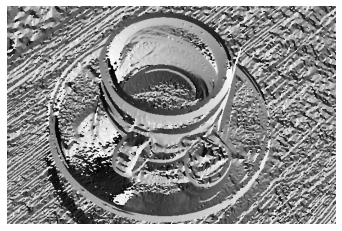

In [16]:
show_image(theta)

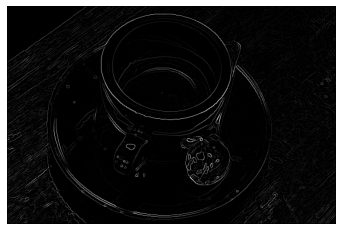

In [17]:
image_new_sup = non_max_suppression(image_new, theta)
show_image(image_new_sup) ## intensity values are still different but edge thickness become uniform

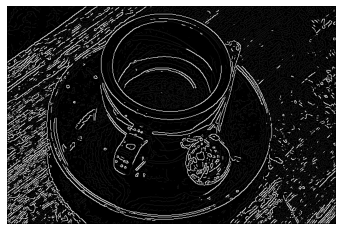

In [18]:
image_new_thr, _ , _ = threshold(image_new_sup)
show_image(image_new_thr)

In [19]:
unique_elements, counts_elements = np.unique(image_new_thr, return_counts=True)

In [20]:
unique_elements

array([  0,  25, 255])

In [21]:
counts_elements

array([177154,  36077,  18833], dtype=int64)

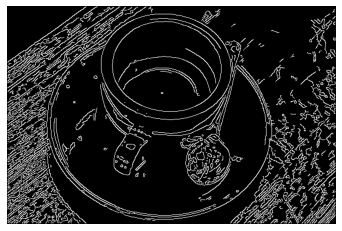

In [22]:
image_new_hys = hysteresis(image_new_thr)
show_image(image_new_hys)

In [23]:
unique_elements, counts_elements = np.unique(image_new_hys, return_counts=True)

In [24]:
unique_elements

array([  0, 255])

In [25]:
counts_elements

array([205865,  26199], dtype=int64)

In [26]:
from skimage.feature import canny
from skimage.color import rgb2gray

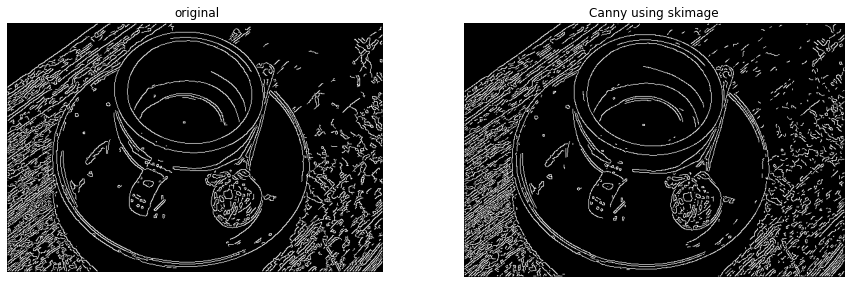

In [34]:
sk_image_gray = rgb2gray(image)
plot_comparison(image_new_hys, canny(sk_image_gray, low_threshold = 0.14, high_threshold = 0.17 ) , 'Canny using skimage')